In [2]:
include("Main_module.jl")
using .TDQMC

In [3]:
using DataFrames, CSV, PyPlot

In [4]:
df = CSV.read("Ground_Guide_Wave.csv", DataFrame)
tr = Matrix(CSV.read("Ground_Trajectory.csv", DataFrame))

In [5]:
Electron_num = size(tr, 1)
Ensemble_num = size(tr, 2)
Total_num = Electron_num * Ensemble_num

250

In [6]:
initial_range = df[:, Total_num+1];         #最后一列保存的是空间的离散信息
Raw_Array = reshape(complex(Matrix(@. abs(parse(Complex{Float64}, df[:, 1:Total_num])))), (3001, Electron_num, Ensemble_num));          # 500代表的是系综*电子数的数目,因为是单电子所以不需要reshape

In [7]:
s_range = initial_range[end]
s_num = length(initial_range)

3001

In [8]:
l_range = 30.0
l_num = extend_num(s_range, l_range, s_num)

3001

In [9]:
P = Parameter{Float64,Int64}(space_N = l_num, scope = l_range, Δt = 0.05, step_t = 100)

Parameter{Float64, Int64}(1, 250, [1, -1], 3001, 30.0, 0.02, 0.0008, range(-30.0, stop=30.0, length=3001), 0.05, 5000)

In [10]:
Raw_GuideWave = stitch_Matrix(Raw_Array, l_num)

1×250 Matrix{Vector{ComplexF64}}:
 [5.32687e-13+0.0im, 1.06544e-12+0.0im, 1.59834e-12+0.0im, 2.13145e-12+0.0im, 2.66484e-12+0.0im, 3.19859e-12+0.0im, 3.73276e-12+0.0im, 4.26743e-12+0.0im, 4.80268e-12+0.0im, 5.33857e-12+0.0im  …  5.33857e-12+0.0im, 4.80268e-12+0.0im, 4.26743e-12+0.0im, 3.73276e-12+0.0im, 3.19859e-12+0.0im, 2.66484e-12+0.0im, 2.13145e-12+0.0im, 1.59834e-12+0.0im, 1.06544e-12+0.0im, 5.32687e-13+0.0im]  …  [5.32687e-13+0.0im, 1.06544e-12+0.0im, 1.59834e-12+0.0im, 2.13145e-12+0.0im, 2.66484e-12+0.0im, 3.19859e-12+0.0im, 3.73276e-12+0.0im, 4.26743e-12+0.0im, 4.80268e-12+0.0im, 5.33857e-12+0.0im  …  5.33857e-12+0.0im, 4.80268e-12+0.0im, 4.26743e-12+0.0im, 3.73276e-12+0.0im, 3.19859e-12+0.0im, 2.66484e-12+0.0im, 2.13145e-12+0.0im, 1.59834e-12+0.0im, 1.06544e-12+0.0im, 5.32687e-13+0.0im]

In [11]:
Dy = Dynamics{Float64}(Trajectory = tr, Guide_Wave = Raw_GuideWave, Displace = zeros(eltype(tr), (P.step_t + 1, Ensemble_num, Electron_num)), 
Time = zeros(typeof(P.Δt), Ensemble_num));
df = nothing
Raw_DuideWave = nothing
Raw_Array = nothing
tr = nothing
GC.gc()

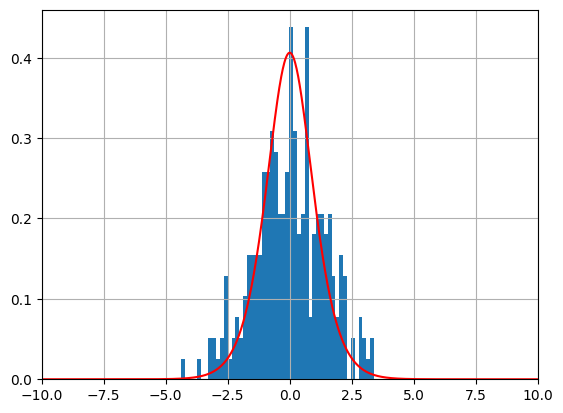

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\86187\.julia\packages\PyCall\3fwVL\src\numpy.jl:67


(-10.0, 10.0)

In [12]:
hist(Dy.Trajectory', 50, density = true);
plot(P.sampling, abs2.(Dy.Guide_Wave[1]), color = "red")      #说明长度能够吻合上
grid()
xlim(-10, 10)

In [13]:
parallel_Evolution!(P, Dy)

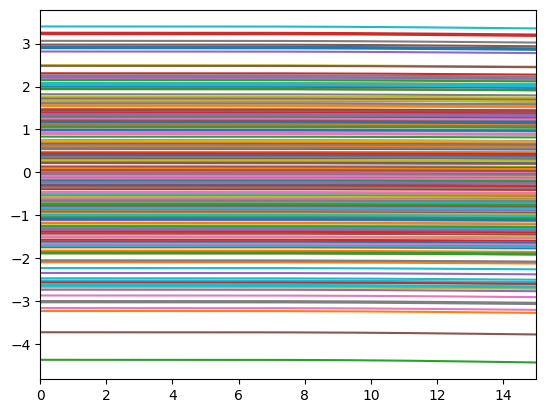

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\86187\.julia\packages\PyCall\3fwVL\src\numpy.jl:67


(0.0, 15.0)

In [13]:
plot(real(P.Δt).* (0:P.step_t), Dy.Displace[:, :, 1])
#ylim(-l_range, l_range)
xlim(0, P.Δt * P.step_t)

In [36]:
findall(x -> abs(x) >= 150, Dy.Displace[:, :, 1])


CartesianIndex{2}[]

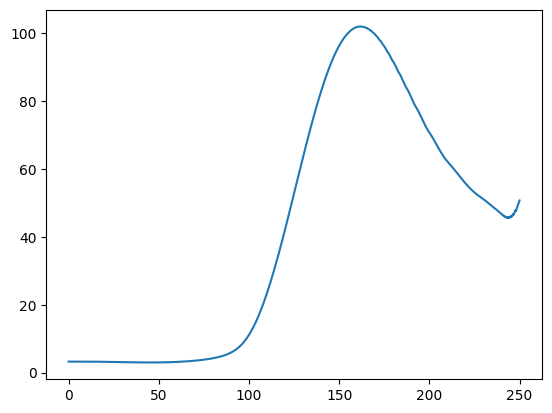

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000A26EB790>

In [34]:
plot(real(P.Δt).* (0:P.step_t), Dy.Displace[:, 4, 1])

In [16]:
Dy.Displace = reshape(Matrix(CSV.read("Displace_Ensemble.csv", DataFrame))[:, 1:Ensemble_num], (P.step_t+1, Ensemble_num, Electron_num))
frequency, Total_ft_dipole, Total_ft_acc = HHG(P, Dy)

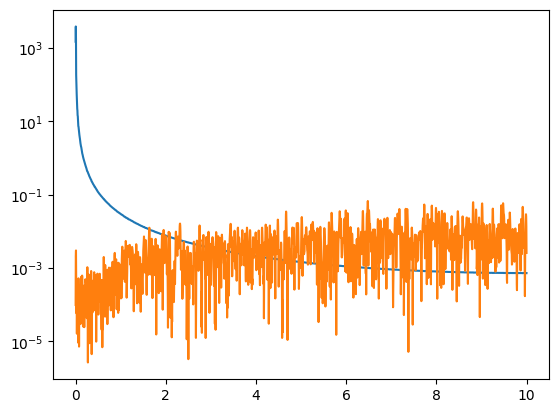

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000007C1DEE20>

In [17]:
semilogy(frequency, abs2.(Total_ft_dipole ./ (P.step_t * P.Δt)))
semilogy(frequency, abs2.(Total_ft_acc ./ (P.step_t * P.Δt)))
#xticks(0.05 * collect(0:2:20), collect(0:2:20))

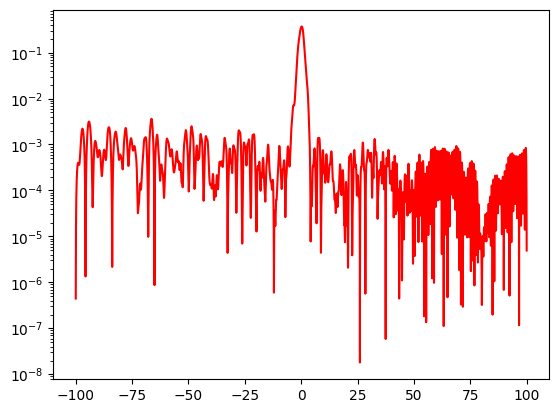

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000007FE07790>

In [25]:
semilogy(P.sampling, abs2.(Dy.Guide_Wave[3]), color = "red")      #说明长度能够吻合上